# Conjunto de dados NYC Benchmarking

### Objetivo prever Energy Star Score

In [59]:
from pandas import read_csv, concat, get_dummies, DataFrame
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = read_csv('01-dados/03-dataset.csv')
data.head()

,Order,Property Id,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Address 2,...,Source EUI (kBtu/ft²),Release Date,Water Required?,DOF Benchmarking Submission Status,Latitude,Longitude,Community Board,Council District,Census Tract,NTA
0,1,13286,201/205,13286,201/205,1013160001,1013160001,1037549,201/205 East 42nd st.,Not Available,...,619.4,05/01/2017 05:32:03 PM,No,In Compliance,40.750791,-73.973963,6.0,4.0,88.0,Turtle Bay-East Midtown ...
1,2,28400,NYP Columbia (West Campus),28400,NYP Columbia (West Campus),1021380040,1-02138-0040,1084198; 1084387;1084385; 1084386; 1084388; 10...,622 168th Street,Not Available,...,404.3,04/27/2017 11:23:27 AM,No,In Compliance,40.841402,-73.942568,12.0,10.0,251.0,Washington Heights South ...
2,3,4778226,MSCHoNY North,28400,NYP Columbia (West Campus),1021380030,1-02138-0030,1063380,3975 Broadway,Not Available,...,Not Available,04/27/2017 11:23:27 AM,No,In Compliance,40.840427,-73.940249,12.0,10.0,251.0,Washington Heights South ...
3,4,4778267,Herbert Irving Pavilion & Millstein Hospital,28400,NYP Columbia (West Campus),1021390001,1-02139-0001,1087281; 1076746,161 Fort Washington Ave,177 Fort Washington Ave,...,Not Available,04/27/2017 11:23:27 AM,No,In Compliance,40.840746,-73.942854,12.0,10.0,255.0,Washington Heights South ...
4,5,4778288,Neuro Institute,28400,NYP Columbia (West Campus),1021390085,1-02139-0085,1063403,710 West 168th Street,Not Available,...,Not Available,04/27/2017 11:23:27 AM,No,In Compliance,40.841559,-73.942528,12.0,10.0,255.0,Washington Heights South ...


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11746 entries, 0 to 11745
Data columns (total 60 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Order                                                       11746 non-null  int64  
 1   Property Id                                                 11746 non-null  int64  
 2   Property Name                                               11746 non-null  object 
 3   Parent Property Id                                          11746 non-null  object 
 4   Parent Property Name                                        11746 non-null  object 
 5   BBL - 10 digits                                             11735 non-null  object 
 6   NYC Borough, Block and Lot (BBL) self-reported              11746 non-null  object 
 7   NYC Building Identification Number (BIN)                    11746 non-null  object 
 

### Convertendo os dados para o tipo correto 

In [4]:
data = data.replace({'Not Available': np.nan})

for coluna in list(data.columns):
    if ('ft²' in coluna or 'kBtu' in coluna or 'Metric Tons C02e' in coluna or 'kWh' in coluna or
        'therms' in coluna or 'gal' in coluna or 'Score' in coluna):
        data[coluna] = data[coluna].astype(float)

In [5]:
data.describe()

,Order,Property Id,DOF Gross Floor Area,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,ENERGY STAR Score,...,Weather Normalized Site Electricity (kWh),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Latitude,Longitude,Community Board,Council District,Census Tract
count,11746.000000,1.174600e+04,1.162800e+04,1.174400e+04,3741.000000,1484.000000,11746.000000,11746.000000,11746.000000,9642.000000,...,1.096000e+04,1.174600e+04,7.762000e+03,7762.000000,11583.000000,9483.000000,9483.000000,9483.000000,9483.000000,9483.000000
mean,7185.759578,3.642958e+06,1.732695e+05,1.605524e+05,22778.682010,12016.825270,1948.738379,1.289971,98.762557,59.854594,...,1.768752e+06,1.673739e+05,1.591798e+04,136.172432,385.908029,40.754379,-73.957057,7.140673,15.771275,4977.596647
std,4323.859984,1.049070e+06,3.367055e+05,3.095746e+05,55094.441422,27959.755486,30.576386,4.017484,7.501603,29.993586,...,9.389154e+06,3.189238e+05,1.529524e+05,1730.726938,9312.736225,0.080120,0.046337,3.954129,15.674375,13520.422990
min,1.000000,7.365000e+03,5.002800e+04,5.400000e+01,0.000000,0.000000,1600.000000,0.000000,0.000000,1.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,40.516065,-74.243582,1.000000,1.000000,1.000000
25%,3428.250000,2.747222e+06,6.524000e+04,6.520100e+04,4000.000000,1720.750000,1927.000000,1.000000,100.000000,37.000000,...,3.019974e+05,6.699400e+04,2.595400e+03,27.150000,99.400000,40.707226,-73.984662,4.000000,4.000000,100.000000
50%,6986.500000,3.236404e+06,9.313850e+04,9.132400e+04,8654.000000,5000.000000,1941.000000,1.000000,100.000000,65.000000,...,5.416312e+05,9.408000e+04,4.692500e+03,45.095000,124.900000,40.759130,-73.962810,7.000000,9.000000,201.000000
75%,11054.500000,4.409092e+06,1.596140e+05,1.532550e+05,20000.000000,12000.000000,1966.000000,1.000000,100.000000,85.000000,...,1.284677e+06,1.584140e+05,8.031875e+03,70.805000,162.750000,40.817623,-73.932443,9.000000,33.000000,531.500000
max,14993.000000,5.991312e+06,1.354011e+07,1.421712e+07,962428.000000,591640.000000,2019.000000,161.000000,100.000000,100.000000,...,4.958273e+08,1.421712e+07,6.594604e+06,96305.690000,912801.100000,40.912869,-73.715543,56.000000,51.000000,155101.000000


In [6]:
(data.isnull().sum()/len(data)*100).sort_values(ascending=False)

Fuel Oil #1 Use (kBtu)                                        99.923378
Diesel #2 Use (kBtu)                                          99.863783
Address 2                                                     98.237698
Fuel Oil #5 & 6 Use (kBtu)                                    94.942959
District Steam Use (kBtu)                                     92.031330
Fuel Oil #4 Use (kBtu)                                        88.753618
3rd Largest Property Use Type - Gross Floor Area (ft²)        87.365912
3rd Largest Property Use Type                                 87.365912
Fuel Oil #2 Use (kBtu)                                        78.026562
2nd Largest Property Use Type                                 68.150860
2nd Largest Property Use - Gross Floor Area (ft²)             68.150860
Metered Areas  (Water)                                        39.238890
Water Intensity (All Water Sources) (gal/ft²)                 33.917930
Water Use (All Water Sources) (kgal)                          33

In [7]:
def ausentes(data):
    vl = data.isnull().sum()
    per = 100 * data.isnull().sum() / len(data)
    tab = concat([vl, per], axis=1)
    df = tab.rename(columns={0:'Valores Ausentes', 1:'% do Valor'})
    df = df[df.iloc[:,1] != 0].sort_values('% do Valor', ascending=False).round(1)
    return df

In [8]:
ausentes(data)

,Valores Ausentes,% do Valor
Fuel Oil #1 Use (kBtu),11737,99.9
Diesel #2 Use (kBtu),11730,99.9
Address 2,11539,98.2
Fuel Oil #5 & 6 Use (kBtu),11152,94.9
District Steam Use (kBtu),10810,92.0
Fuel Oil #4 Use (kBtu),10425,88.8
3rd Largest Property Use Type - Gross Floor Area (ft²),10262,87.4
3rd Largest Property Use Type,10262,87.4
Fuel Oil #2 Use (kBtu),9165,78.0
2nd Largest Property Use Type,8005,68.2


In [9]:
# Pegando o nome das colunas
aus = ausentes(data)
col_name = list(aus[aus['% do Valor'] > 50].index)
print('Colunas que deve remover %d.' % len(col_name))

Colunas que deve remover 11.


In [10]:
data = data.drop(columns=list(col_name))

Text(0.5, 1.0, 'Distribuição de Energia')

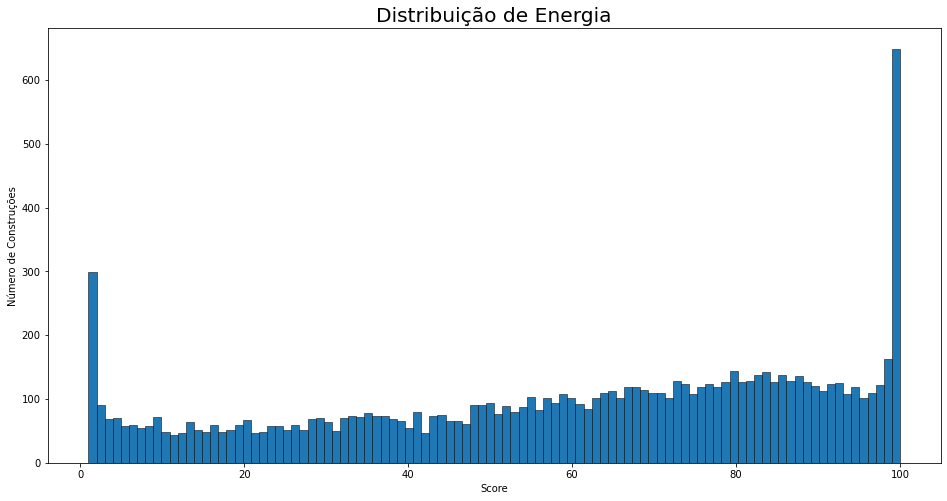

In [11]:
data = data.rename(columns = {'ENERGY STAR Score':'score'})

plt.subplots(figsize=(16,8))
plt.style.use('fivethirtyeight')
plt.hist(data['score'].dropna(), bins=100, edgecolor='k')
plt.xlabel('Score')
plt.ylabel('Número de Construções')
plt.title('Distribuição de Energia')

Text(0.5, 1.0, 'Site EUI Distribuition')

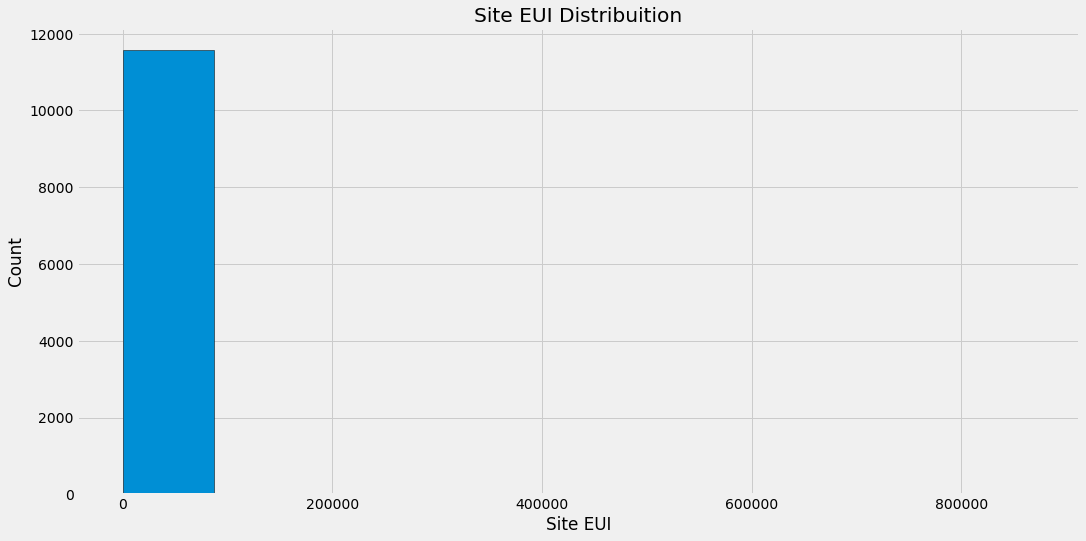

In [12]:
plt.subplots(figsize=(16,8))
plt.hist(data['Site EUI (kBtu/ft²)'].dropna(), bins=10, edgecolor='black')
plt.xlabel('Site EUI')
plt.ylabel('Count')
plt.title('Site EUI Distribuition')

In [13]:
data['Site EUI (kBtu/ft²)'].describe()

count     11583.000000
mean        280.071484
std        8607.178877
min           0.000000
25%          61.800000
50%          78.500000
75%          97.600000
max      869265.000000
Name: Site EUI (kBtu/ft²), dtype: float64

In [14]:
data['Site EUI (kBtu/ft²)'].dropna().sort_values().tail(10)

3173     51328.8
3170     51831.2
3383     78360.1
8269     84969.6
3263     95560.2
8268    103562.7
8174    112173.6
3898    126307.4
7       143974.4
8068    869265.0
Name: Site EUI (kBtu/ft²), dtype: float64

In [15]:
data.loc[data['Site EUI (kBtu/ft²)'] == 869265, :]

,Order,Property Id,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Postal Code,...,Source EUI (kBtu/ft²),Release Date,Water Required?,DOF Benchmarking Submission Status,Latitude,Longitude,Community Board,Council District,Census Tract,NTA
8068,9984,4414323,234 Skillman,Not Applicable: Standalone Property,Not Applicable: Standalone Property,3028937502,3028937502,"3390250 , 3338313",234 Skillman avenue,11211,...,912801.1,05/01/2017 11:34:14 PM,NaN,In Compliance,40.716233,-73.94141,1.0,34.0,477.0,East Williamsburg ...


## Removendo Outliers

In [16]:
quartile1 = data['Site EUI (kBtu/ft²)'].describe()['25%']
quartile2 = data['Site EUI (kBtu/ft²)'].describe()['75%']

dif = quartile2 - quartile1

data = data[(data['Site EUI (kBtu/ft²)'] > (quartile1 - 3 * dif)) &
            (data['Site EUI (kBtu/ft²)'] < (quartile2 + 3 * dif))]

Text(0.5, 1.0, 'Site EUI Distribuition')

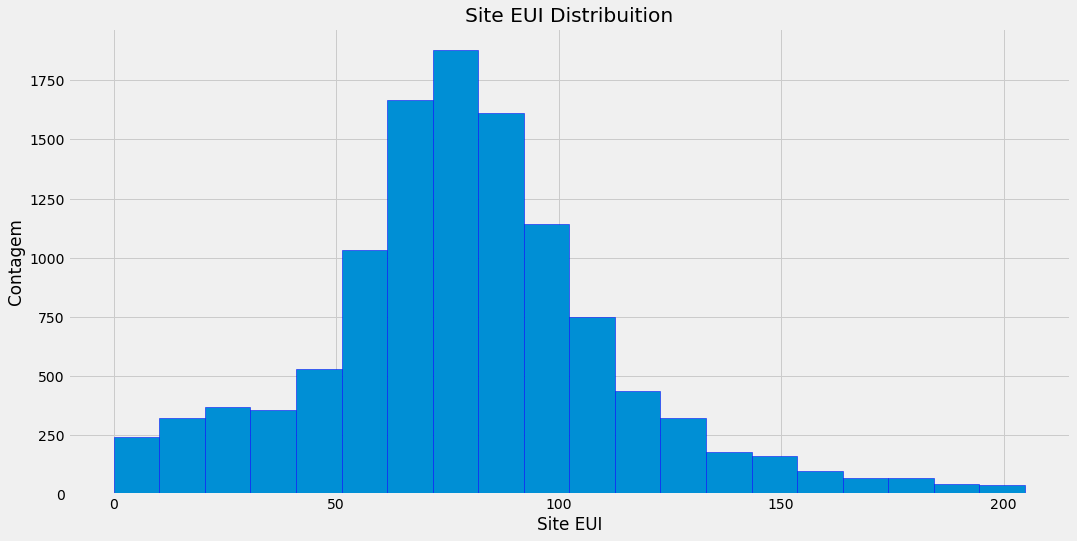

In [17]:
plt.figure(figsize=(16,8))
plt.hist(data['Site EUI (kBtu/ft²)'].dropna(), bins=20, edgecolor='b')
plt.xlabel('Site EUI')
plt.ylabel('Contagem')
plt.title('Site EUI Distribuition')

## Relacionamentos

In [18]:
vl = data.dropna(subset=['score'])
vl = vl['Largest Property Use Type'].value_counts()
vl = list(vl[vl.values > 100].index)

Text(0.5, 1.0, 'Density Plot de Energy Star Scores por Building Type')

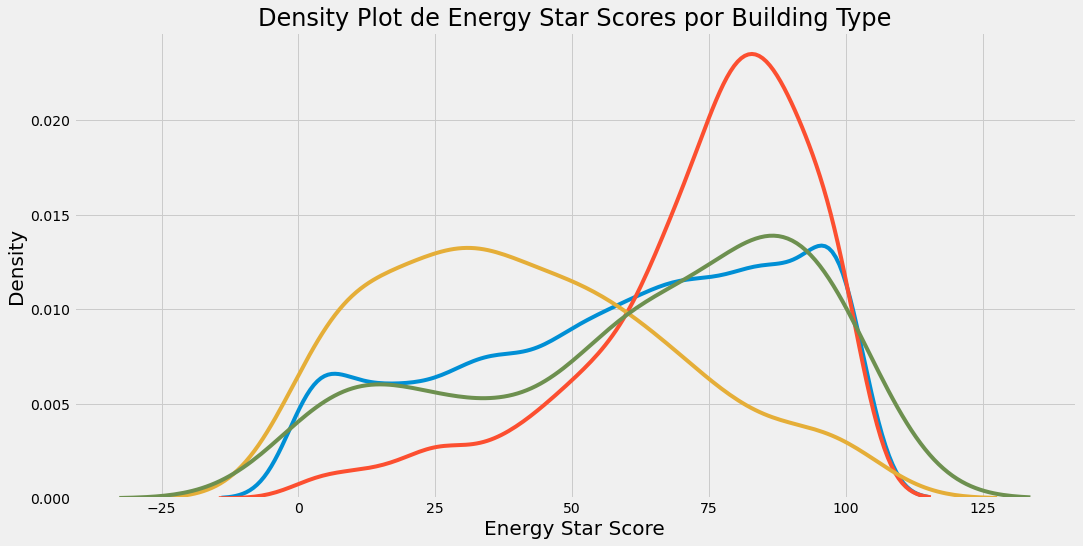

In [19]:
plt.figure(figsize=(16,8))

for b_type in vl:
    subset = data[data['Largest Property Use Type'] == b_type]
    
    sns.kdeplot(subset['score'].dropna(), label = b_type, shade = False, alpha = 0.8)
    
plt.xlabel('Energy Star Score', size = 20)
plt.ylabel('Density', size = 20)
plt.title('Density Plot de Energy Star Scores por Building Type', size = 24)

In [20]:
br = data.dropna(subset=['score'])
br = data['Borough'].value_counts()
br = list(br[br.values > 100].index)

Text(0.5, 1.0, 'Density Plot de Energy Star Scores por Borough')

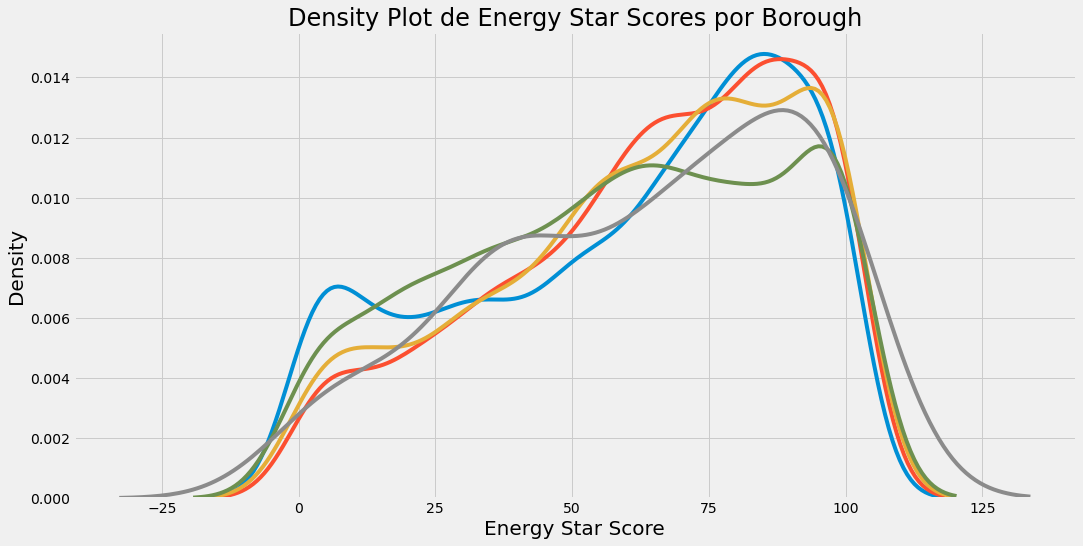

In [21]:
plt.figure(figsize=(16,8))

for b in br:
    subset = data[data['Borough'] == b]
    sns.kdeplot(subset['score'].dropna(), label=br)
    
plt.xlabel('Energy Star Score', size=20)
plt.ylabel('Density', size=20)
plt.title('Density Plot de Energy Star Scores por Borough', size =24)

# Correlação

In [22]:
numeric_subset = data.select_dtypes('number')

for col in numeric_subset.columns:
    if col == 'score':
        next
    else:
        subset['sqrt_' + col] = np.sqrt(subset[col])
        subset['log_' + col] = np.log(subset[col])

categorical_subset = data[['Borough', 'Largest Property Use Type']]

categorical_subset = get_dummies(categorical_subset)

features = concat([numeric_subset, categorical_subset], axis = 1)

features = features.dropna(subset = ['score'])

correlations = features.corr()['score'].dropna().sort_values()

In [23]:
correlations.head(15)

Site EUI (kBtu/ft²)                                          -0.723864
Weather Normalized Site EUI (kBtu/ft²)                       -0.713993
Weather Normalized Source EUI (kBtu/ft²)                     -0.645542
Source EUI (kBtu/ft²)                                        -0.641037
Weather Normalized Site Electricity Intensity (kWh/ft²)      -0.358394
Weather Normalized Site Natural Gas Intensity (therms/ft²)   -0.346046
Weather Normalized Site Natural Gas Use (therms)             -0.135211
Natural Gas Use (kBtu)                                       -0.133648
Year Built                                                   -0.121249
Largest Property Use Type_Multifamily Housing                -0.099751
Largest Property Use Type_Hotel                              -0.096428
Largest Property Use Type_Senior Care Community              -0.054583
Electricity Use - Grid Purchase (kBtu)                       -0.050639
Weather Normalized Site Electricity (kWh)                    -0.048207
Latitu

In [24]:
correlations.tail(15)

Largest Property Use Type_Courthouse                               0.016445
Largest Property Use Type_Financial Office                         0.017172
Property GFA - Self-Reported (ft²)                                 0.017360
Largest Property Use Type - Gross Floor Area (ft²)                 0.018330
Largest Property Use Type_Retail Store                             0.025007
Borough_Queens                                                     0.029545
Largest Property Use Type_Supermarket/Grocery Store                0.030038
Largest Property Use Type_Residence Hall/Dormitory                 0.035407
Order                                                              0.036827
Largest Property Use Type_Hospital (General Medical & Surgical)    0.048410
Borough_Brooklyn                                                   0.050486
Community Board                                                    0.056612
Council District                                                   0.061639
Largest Prop

# Engenharia de Atributos

In [25]:
features = data.copy()

numeric_subset = data.select_dtypes('number')

for col in numeric_subset.columns:
    if col == 'score':
        next
    else:
        numeric_subset['log_' + col] = np.log(numeric_subset[col])
        
categorical_subset = data[['Borough', 'Largest Property Use Type']]
categorical_subset = get_dummies(categorical_subset)
features = concat([numeric_subset, categorical_subset], axis = 1)
features.shape

(11319, 104)

# Removendo Colinearidade

In [26]:
def remove_collinear_features(x, threshold):

    y = x['score']
    x = x.drop(columns = ['score'])
    
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            
            if val >= threshold:
                drop_cols.append(col.values[0])

    drops = set(drop_cols)
    x = x.drop(columns = drops)
    x = x.drop(columns = ['Weather Normalized Site EUI (kBtu/ft²)', 
                          'Water Use (All Water Sources) (kgal)',
                          'log_Water Use (All Water Sources) (kgal)',
                          'Largest Property Use Type - Gross Floor Area (ft²)'])
    
    x['score'] = y
               
    return x

In [27]:
features = remove_collinear_features(features, 0.6)

In [32]:
features  = features.dropna(axis=1, how = 'all')
features.shape

(11319, 64)

# Traino e Teste

In [36]:
n_score = features[features['score'].isna()]
score = features[features['score'].notnull()]

print(n_score.shape)
print(score.shape)

(1858, 64)
(9461, 64)


In [39]:
x = score.drop(columns='score')
y = DataFrame(score['score'])

x = x.replace({np.inf: np.nan, -np.inf: np.nan})

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(7568, 63)
(1893, 63)
(7568, 1)
(1893, 1)


In [41]:
x_test = MinMaxScaler().fit_transform(x_test)
y_test = MinMaxScaler().fit_transform(y_test)

In [45]:
y_train = np.array(y_train).reshape((-1,))
y_test = np.array(y_test).reshape((-1,))

In [50]:
x_train.isnull().sum()

Order                                                             0
Property Id                                                       0
DOF Gross Floor Area                                             40
Year Built                                                        0
Number of Buildings - Self-reported                               0
                                                                 ..
Largest Property Use Type_Strip Mall                              0
Largest Property Use Type_Supermarket/Grocery Store               0
Largest Property Use Type_Urgent Care/Clinic/Other Outpatient     0
Largest Property Use Type_Wholesale Club/Supercenter              0
Largest Property Use Type_Worship Facility                        0
Length: 63, dtype: int64

In [53]:
imput = SimpleImputer(missing_values=np.nan, strategy='mean')
imput.fit(x)
x_train = imput.transform(x_train)

SimpleImputer()

In [56]:
x_test = imput.transform(x_test)

# Random Forest Regressor

In [63]:
rfr = RandomForestRegressor(n_jobs=-1)
rfr.fit(x_train, y_train)
mean_squared_error(y_test, rfr.predict(x_test))
rfr.score(x_test, y_test)

-107605.82155166076

In [65]:
n_estimators = [100, 500, 900, 1100, 1500]
max_depth = [2, 3, 5, 10, 15]
min_samples_leaf = [1, 2, 4, 6, 8]
min_samples_split = [2, 4, 6, 10]
max_features = ['auto', 'sqrt', 'log2']

params= {'n_estimators': n_estimators,
         'max_depth': max_depth,
         'min_samples_leaf': min_samples_leaf,
         'min_samples_split': min_samples_split,
         'max_features': max_features}

rscv = RandomizedSearchCV(rfr, param_distributions=params, n_iter=25, return_train_score=True,n_jobs=-1)
rscv.fit(x_train, y_train)
mean_squared_error(y_test, rscv.predict(x_test))
rscv.score(x_test, y_test)

-112373.63444908638

# Gradient Boosting Regressor

In [62]:
gbr = GradientBoostingRegressor()
gbr.fit(x_train, y_train)
mean_squared_error(y_test, gbr.predict(x_test))
gbr.score(x_test,y_test)

-112924.55243818102

In [66]:
loss = ['ls', 'lad', 'huber']
n_estimators = [100, 500, 900, 1100, 1500]
max_depth = [2, 3, 5, 10, 15]
min_samples_leaf = [1, 2, 4, 6, 8]
min_samples_split = [2, 4, 6, 10]
max_features = ['auto', 'sqrt', 'log2', None]

params = {'loss': loss,
          'n_estimators': n_estimators,
          'max_depth': max_depth,
          'min_samples_leaf': min_samples_leaf,
          'min_samples_split': min_samples_split,
          'max_features': max_features}

rscv = RandomizedSearchCV(gbr, param_distributions=params, n_iter=25, return_train_score=True,n_jobs=-1)
rscv.fit(x_train, y_train)
mean_squared_error(y_test, rscv.predict(x_test))
rscv.score(x_test, y_test)

-137155.46234779508